### Setup

In [60]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
style.use("ggplot")

### Load Dataset and Randomization

In [64]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


### Preprocess Features

In [65]:
def preprocess_features(california_housing_dataframe):
    """Preprocess input features from California housing dataset.
    
    Args:
      california_housing_dataframe: A Pandas DataFrame containing data from California housing dataset.
    Returns:
      A DataFrame that contains the features to be used in model subsuming synthetic features.
    """
    # Multiple features
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    processed_features = selected_features.copy()
    # Create synthetic feature.
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"])
    return processed_features

### Preprocess Targets

In [66]:
def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing dataset.
    
    Args:
      california_housing_dataframe: A Pandas DataFrame containing data from California housing dataset.
    Returns:
      A DataFrame that contains the target features.
    """
    output_targets = pd.DataFrame()
    # Scale the targets to be in units of thousands of dollars.
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

### Prepare Training and Target examples

In [67]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.6,2643.9,539.3,1432.5,501.1,3.9,2.0
std,2.1,2.0,12.6,2178.7,421.5,1157.0,384.4,1.9,1.2
min,32.5,-124.3,2.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1457.0,296.0,790.8,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,435.0,1169.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3146.2,650.0,1731.2,604.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


In [68]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.3
std,116.0
min,15.0
25%,119.8
50%,180.6
75%,264.9
max,500.0


### Prepare Validation set

In [69]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.5,2643.1,539.6,1422.5,501.6,3.9,2.0
std,2.1,2.0,12.6,2183.1,421.5,1125.6,384.8,1.9,1.0
min,32.5,-124.3,1.0,8.0,1.0,9.0,1.0,0.5,0.1
25%,34.0,-121.8,18.0,1471.0,298.0,788.8,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2124.0,431.0,1161.0,405.0,3.6,1.9
75%,37.7,-118.0,37.0,3164.0,647.0,1693.0,607.0,4.8,2.3
max,41.9,-114.6,52.0,32054.0,5290.0,15507.0,5050.0,15.0,34.2


In [70]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,207.2
std,115.9
min,15.0
25%,118.8
50%,179.8
75%,265.1
max,500.0


### Plot Latitude/Longitude vs. Median House Value

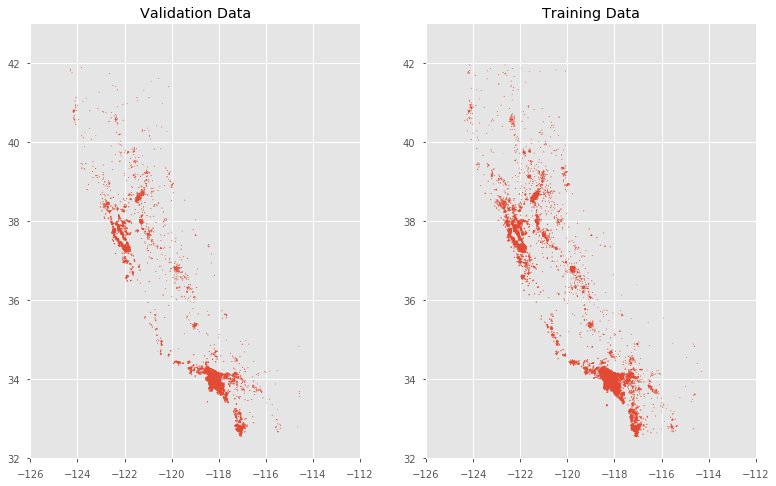

In [71]:
plt.figure(figsize=(13, 8))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title("Validation Data")
ax1.set_autoscaley_on(False)
ax1.set_ylim([32, 43])
ax1.set_autoscalex_on(False)
ax1.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            validation_targets["median_house_value"]/validation_targets["median_house_value"].max())

ax2 = plt.subplot(1, 2, 2)
ax2.set_title("Training Data")
ax2.set_autoscaley_on(False)
ax2.set_ylim([32, 43])
ax2.set_autoscalex_on(False)
ax2.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            training_targets["median_house_value"]/training_targets["median_house_value"].max())
_ = plt.plot()

### Input Function

In [72]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Construct Feature Columns

In [ ]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.

    Args:
      input_features: The names of the numerical input features to use.
    Returns:
      A set of feature columns
    """
    return set([tf.feature_column.numeri])